# COVID Chest X-ray images Detection using CNN

### Importing necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv

import random
import os
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten
from keras.layers import Dense,Dropout
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

---
### Data Analysis

In [ ]:
df_train = pd.read_csv('train.csv')

In [ ]:
df_train.head()

,Image,Label
0,597631776.jpeg,normal
1,35266064.jpeg,virus
2,467414642.jpeg,normal
3,35667640.jpeg,normal
4,618841263.jpeg,normal


In [ ]:
df_train.describe()

,Image,Label
count,1196,1196
unique,1196,3
top,597631776.jpeg,normal
freq,1,468


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1196 entries, 0 to 1195
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Image   1196 non-null   object
 1   Label   1196 non-null   object
dtypes: object(2)
memory usage: 18.8+ KB


In [ ]:
df_train['Label'].value_counts()

normal    468
virus     433
covid     295
Name: Label, dtype: int64

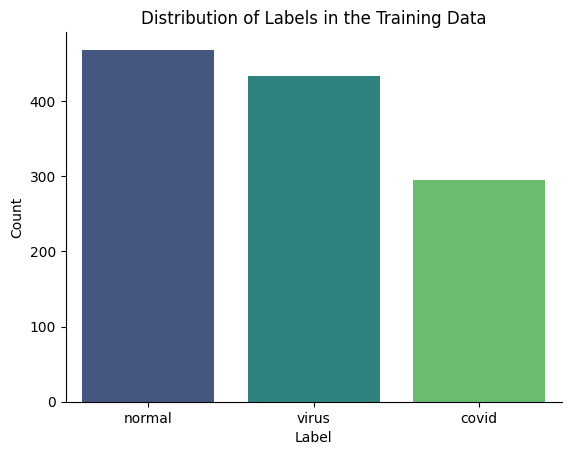

In [ ]:
countplot = sns.countplot(x='Label', data=df_train, palette='viridis')

plt.title('Distribution of Labels in the Training Data')
plt.xlabel('Label')
plt.ylabel('Count')
sns.despine()
plt.show()

In [ ]:
covid_path = "/kaggle/input/covid-19/train/covid/"
normal_path = "/kaggle/input/covid-19/train/normal/"
virus_path = "/kaggle/input/covid-19/train/virus/"

def plotXRAY(url, rowsCount, colsCount, title):
    data = os.listdir(url)
    fig, ax = plt.subplots(rowsCount, colsCount, figsize=(15,15))


    fig.suptitle(title, fontsize=20)

    for row in range(rowsCount):
        for col in range(colsCount):
            img = plt.imread(url + data[row])
            ax[row, col].imshow(img, cmap="gray")


            ax[row, col].axis('off')


    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    plt.show()

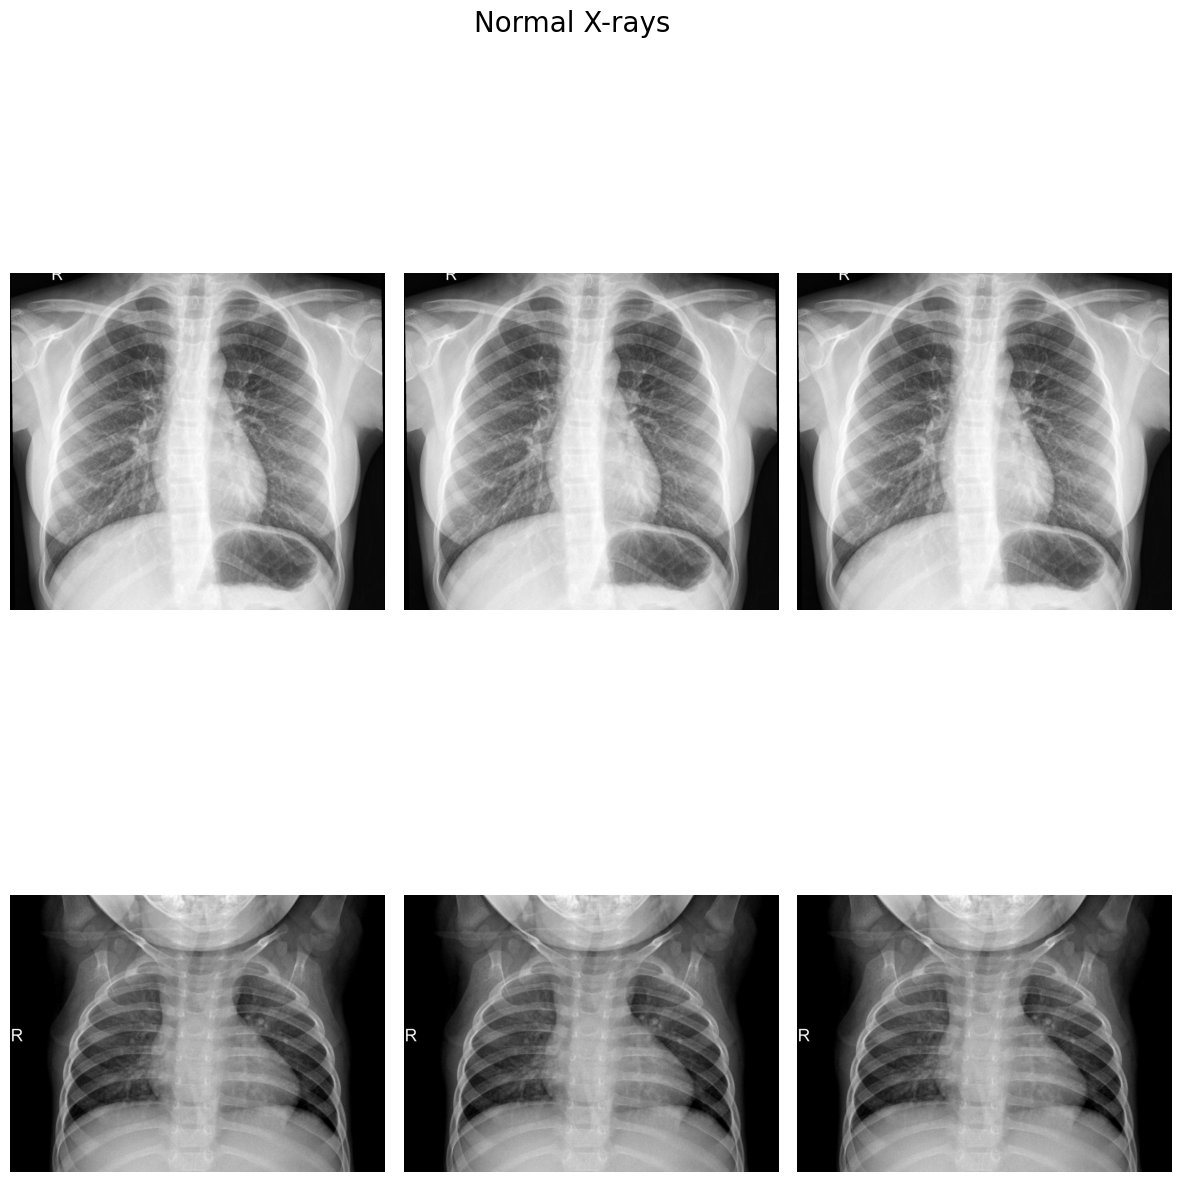

In [ ]:
plotXRAY(normal_path, 2, 3, "Normal X-rays")

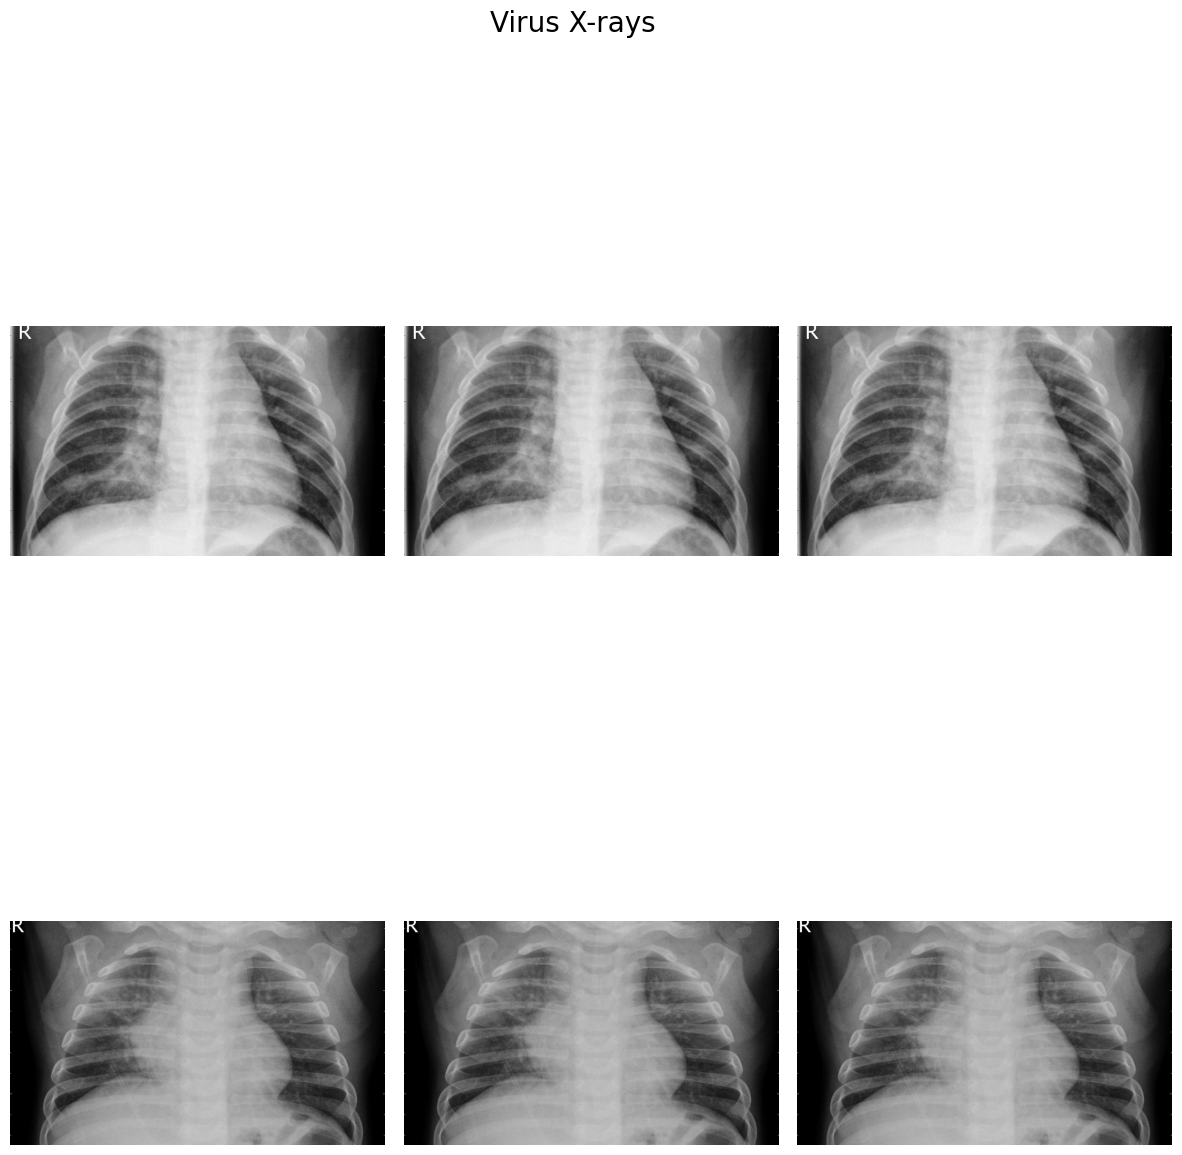

In [ ]:
plotXRAY(virus_path, 2, 3, "Virus X-rays")

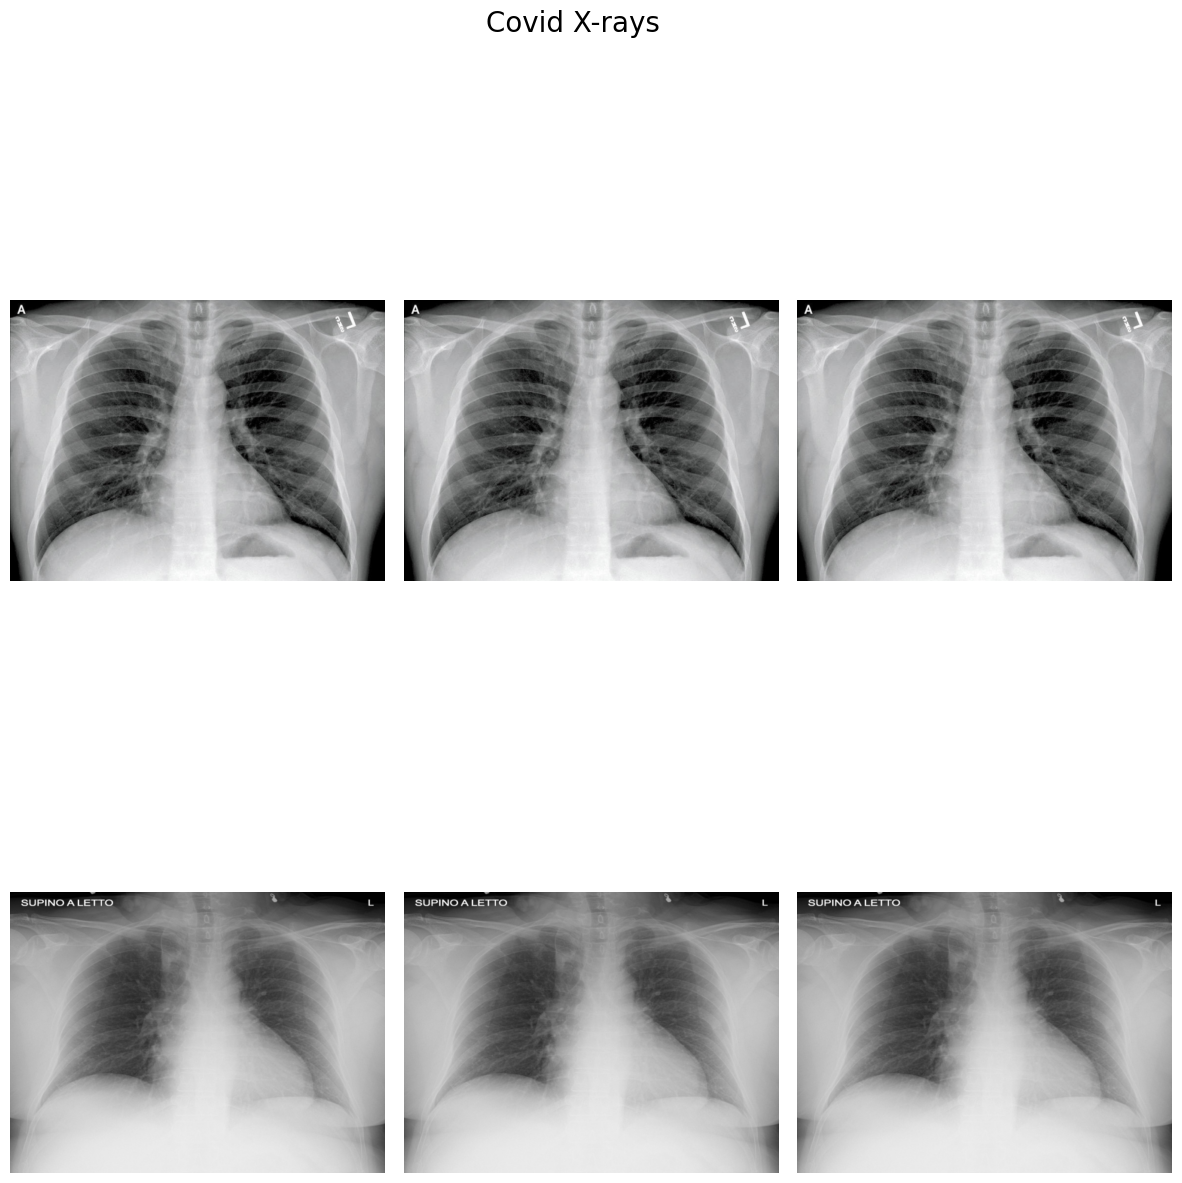

In [ ]:
plotXRAY(covid_path, 2, 3, "Covid X-rays")

---

### Images Preprocessing

In [ ]:
covid_path = "/kaggle/input/covid-19/train/covid/"
normal_path = "/kaggle/input/covid-19/train/normal/"
virus_path = "/kaggle/input/covid-19/train/virus/"

In [ ]:
TrainData_Dir = '/kaggle/input/covid-19/train/'
df = pd.read_csv(r'train.csv')

In [ ]:
df.head()

,Image,Label
0,597631776.jpeg,normal
1,35266064.jpeg,virus
2,467414642.jpeg,normal
3,35667640.jpeg,normal
4,618841263.jpeg,normal


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255.0, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_data_dir = '/kaggle/input/covid-19/train/'
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,  # Split 20% for validation
    subset='training'
)


train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
validation_dataset = train_dataset.take(int(0.2 * len(train_dataset)))
train_dataset = train_dataset.skip(int(0.2 * len(train_dataset)))

Found 1196 files belonging to 3 classes.
Using 957 files for training.


In [ ]:
model_cnn = tf.keras.Sequential([

    # Block 1
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),

    # Block 2
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', ),
    tf.keras.layers.Conv2D(64,(3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),

    # Block 3
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),


    # Block 4
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(256,(3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2), padding='same'),
    tf.keras.layers.Dropout(0.3),

    #Output
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense( 3 , activation='softmax')
])


model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history = model_cnn.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/30
24/24 [==============================] - 303s 12s/step - loss: 7.8891 - accuracy: 0.4549 - val_loss: 0.6493 - val_accuracy: 0.7031 - lr: 0.0010
Epoch 2/30
24/24 [==============================] - 290s 12s/step - loss: 0.7876 - accuracy: 0.6614 - val_loss: 0.6470 - val_accuracy: 0.6458 - lr: 0.0010
Epoch 3/30
24/24 [==============================] - 317s 13s/step - loss: 0.6132 - accuracy: 0.7516 - val_loss: 0.5504 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 4/30
24/24 [==============================] - 307s 13s/step - loss: 0.4886 - accuracy: 0.8026 - val_loss: 0.3132 - val_accuracy: 0.8854 - lr: 0.0010
Epoch 5/30
24/24 [==============================] - 314s 13s/step - loss: 0.3997 - accuracy: 0.8458 - val_loss: 0.3789 - val_accuracy: 0.8542 - lr: 0.0010
Epoch 6/30
24/24 [==============================] - 294s 12s/step - loss: 0.3342 - accuracy: 0.8824 - val_loss: 0.1543 - val_accuracy: 0.9427 - lr: 0.0010
Epoch 7/30
24/24 [==============================] - 289s 12s/step - lo

---

### Model Building

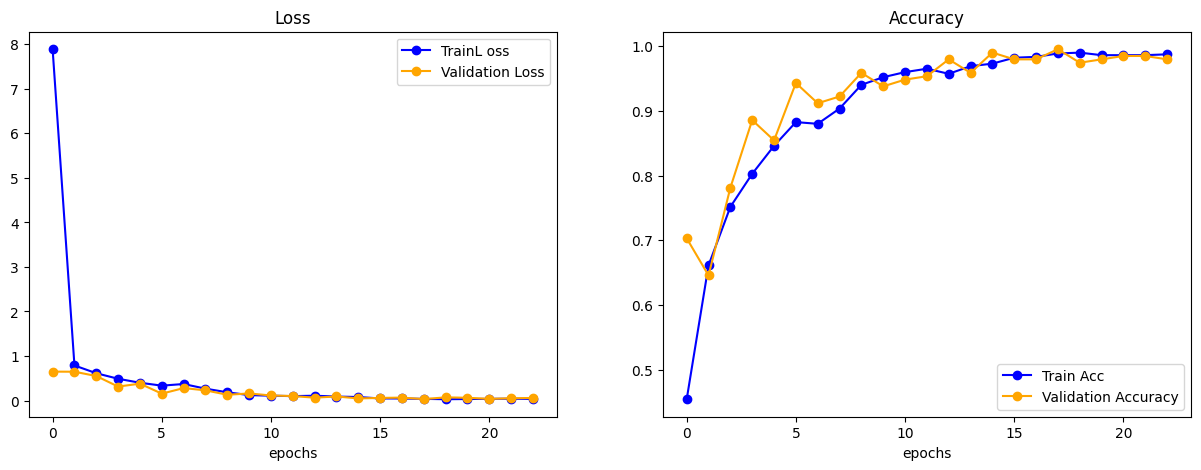

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

epochs = range(len(history.history["loss"]))

plt.figure(figsize=(15,5))
#plt.style.use('ggplot')

#plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-' , label = "TrainL oss")
plt.plot(epochs, val_loss, 'o-' , color='orange', label = "Validation Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.legend()

#plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-' , label = "Train Acc")
plt.plot(epochs, val_accuracy, 'o-' , color='orange' , label = "Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("epochs")
plt.legend()

plt.style.use('default')

In [ ]:
score = model_cnn.evaluate(validation_dataset, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03346792235970497
Test accuracy: 0.9947916865348816


---
### Submission and Prediction

In [ ]:
class_names = ['covid', 'normal', 'virus']
images_dir = "/kaggle/input/covid-19/test/"
cnn_predictions=[]

#model Predictions
for image_file in os.listdir(images_dir):
    image_path = os.path.join(images_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224,224))
    cnn_prediction = model_cnn.predict(np.expand_dims(image, axis = 0))
    predicted_class = class_names[np.argmax(cnn_prediction)]
    cnn_predictions.append((image_file, predicted_class))
with open("cnn39_Submission.csv", 'w', newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Image", "Label"])
    for prediction in cnn_predictions:
        writer.writerow(prediction)
pred = pd.read_csv("cnn39_Submission.csv")
pred.head()

1/1 [==============================] - 0s 103ms/step


,Image,Label
0,545726869.jpeg,normal
1,460439802.jpeg,virus
2,9947263.jpeg,virus
3,258346825.jpeg,virus
4,4178595.jpeg,normal


In [ ]:
pred["Label"].value_counts()

normal    198
virus     189
covid     126
Name: Label, dtype: int64